In [1]:
import os

import numpy as np
import json

import pandas as pd

import torch

from matplotlib import pyplot
import seaborn as sns

from tqdm.auto import tqdm

In [2]:
ROOT = './generated/temperature/'
SPLIT_ID = 0

# POS_WEIGHT_PATH = './generated/temperature/weight/2023-11-30-00-score-linear-embedding-positive.pth'
# NEG_WEIGHT_PATH = './generated/temperature/weight/2023-11-30-00-score-linear-embedding-negative.pth'
# TEXT_WEIGHT_PATH = './generated/temperature/weight/2023-11-30-00-score-linear-embedding.pth'
# VISION_WEIGHT_PATH = './generated/temperature/weight/2023-11-30-00-score-linear-clip.pth'

POS_WEIGHT_PATH = './weight/004/environmental/clip_positive.pt'
NEG_WEIGHT_PATH = './weight/004/environmental/clip_negative.pt'
TEXT_WEIGHT_PATH = './weight/004/environmental/clip_text.pt'
VISION_WEIGHT_PATH = './weight/004/environmental/clip_vision.pt'

BATCH_SIZE = 64

EMB_DIMS = 768

In [3]:
from utils import get_score_from_embs

# load models

In [4]:
js = json.load(open(POS_WEIGHT_PATH.replace('.pt', '_stats.json')))
positive_mean, positive_std = js['mean'], js['std']
positive_model = torch.nn.Linear(EMB_DIMS, 1, bias=True).cuda().eval()
positive_model.load_state_dict(torch.load(POS_WEIGHT_PATH))

js = json.load(open(NEG_WEIGHT_PATH.replace('.pt', '_stats.json')))
negative_mean, negative_std = js['mean'], js['std']
negative_model = torch.nn.Linear(EMB_DIMS, 1, bias=True).cuda().eval()
negative_model.load_state_dict(torch.load(NEG_WEIGHT_PATH))

js = json.load(open(TEXT_WEIGHT_PATH.replace('.pt', '_stats.json')))
text_mean, text_std = js['mean'], js['std']
text_model = torch.nn.Linear(EMB_DIMS * 2, 1, bias=True).cuda().eval()
text_model.load_state_dict(torch.load(TEXT_WEIGHT_PATH))

js = json.load(open(VISION_WEIGHT_PATH.replace('.pt', '_stats.json')))
vision_mean, vision_std = js['mean'], js['std']
vision_model = torch.nn.Linear(EMB_DIMS, 1, bias=True).cuda().eval()
vision_model.load_state_dict(torch.load(VISION_WEIGHT_PATH))

<All keys matched successfully>

In [5]:
# class ABRankingLinearModel(torch.nn.Module):
#     def __init__(self, inputs_shape):
#         super(ABRankingLinearModel, self).__init__()
#         self.inputs_shape = inputs_shape
#         self.linear = torch.nn.Linear(inputs_shape, 1)
#     def forward(self, input):
#         output = self.linear(input)
#         return output

# positive_model = ABRankingLinearModel(EMB_DIMS).cuda().eval()
# state_dict = torch.load(POS_WEIGHT_PATH)
# assert state_dict['pooling-strategy'] == 0
# positive_model.load_state_dict(state_dict['model_dict'])
# positive_mean, positive_std = state_dict['mean'], state_dict['standard-deviation']

# negative_model = ABRankingLinearModel(EMB_DIMS).cuda().eval()
# state_dict = torch.load(NEG_WEIGHT_PATH)
# assert state_dict['pooling-strategy'] == 0
# negative_model.load_state_dict(state_dict['model_dict'])
# negative_mean, negative_std = state_dict['mean'], state_dict['standard-deviation']

# text_model = ABRankingLinearModel(EMB_DIMS * 2).cuda().eval()
# state_dict = torch.load(TEXT_WEIGHT_PATH)
# assert state_dict['pooling-strategy'] == 0
# text_model.load_state_dict(state_dict['model_dict'])
# text_mean, text_std = state_dict['mean'], state_dict['standard-deviation']

# vision_model = ABRankingLinearModel(EMB_DIMS).cuda().eval()
# state_dict = torch.load(VISION_WEIGHT_PATH)
# vision_model.load_state_dict(state_dict['model_dict'])
# vision_mean, vision_std = state_dict['mean'], state_dict['standard-deviation']

In [6]:
def worker():

    # load prompts
    prompts = pd.read_csv(os.path.join(ROOT, 'prompt', f'2023-11-30-independent-approx-v1-0{SPLIT_ID}-environmental.csv'))

    # load generated
    
    file_paths = list()
    for file_path in os.listdir(os.path.join(ROOT, f'{SPLIT_ID}', 'image')):
        if file_path.endswith('.jpg'):
            file_paths.append(file_path)
    file_names = np.array([os.path.splitext(i)[0] for i in file_paths])
    name_to_index = {file_name: i for i, file_name in enumerate(file_names)}

    positive_embs = list()
    negative_embs = list()
    image_embs = list()
    positive_prompts = list()
    negative_prompts = list()
    
    for file_name in tqdm(file_names, leave=False):
        
        embedding_path = os.path.join(ROOT, f'{SPLIT_ID}', 'embedding', f'{file_name}.npz')
        
        npz = np.load(embedding_path)
        positive_embs.append(npz['positive_pooler_output'])
        negative_embs.append(npz['negative_pooler_output'])
        
        clip_path = os.path.join(ROOT, f'{SPLIT_ID}', 'clip', f'{file_name}.npy')
        
        image_embs.append(np.load(clip_path))
        
        meta_path = os.path.join(ROOT, f'{SPLIT_ID}', 'meta', f'{file_name}.json')
        
        meta = json.load(open(meta_path))
        
        positive_prompts.append(meta['positive_prompt'])
        negative_prompts.append(meta['negative_prompt'])
        
    positive_embs = np.concatenate(positive_embs, axis=0)
    negative_embs = np.concatenate(negative_embs, axis=0)
    image_embs = np.concatenate(image_embs, axis=0)
    positive_prompts = np.array(positive_prompts)
    negative_prompts = np.array(negative_prompts)

    # calculate
    
    positive_scores = get_score_from_embs(positive_embs, positive_model, BATCH_SIZE)
    negative_scores = get_score_from_embs(negative_embs, negative_model, BATCH_SIZE)
    text_scores = get_score_from_embs(np.concatenate([positive_embs, negative_embs], axis=-1), text_model, BATCH_SIZE)
    image_scores = get_score_from_embs(image_embs, vision_model, BATCH_SIZE)

    positive_scores = (positive_scores - positive_mean) / positive_std
    negative_scores = (negative_scores - negative_mean) / negative_std
    text_scores = (text_scores - text_mean) / text_std
    image_scores = (image_scores - vision_mean) / vision_std
    
    scores = pd.DataFrame(
        zip(positive_prompts, negative_prompts, positive_scores, negative_scores, text_scores, image_scores, file_names), 
        columns=['positive_prompt', 'negative_prompt', 'positive_sigma_score', 'negative_sigma_score', 'embedding_sigma_score', 'clip_sigma_score', 'file_name']
    )
    merged = pd.merge(prompts, scores, on=['positive_prompt', 'negative_prompt'], how='inner')
    
    return merged

In [7]:
results = list()
for SPLIT_ID in range(8):
    results.append(worker())
results = pd.concat(results, ignore_index=True)

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

In [11]:
feature_name = 'clip_sigma_score'

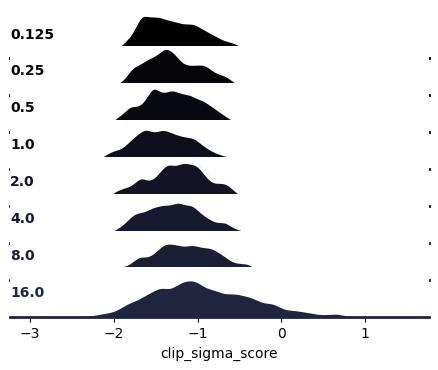

In [12]:
# Initialize the FacetGrid object
pal = sns.cubehelix_palette(8, rot=-.25, light=.0)
# pal = sns.cubehelix_palette(8, rot=-.25, light=.7)
g = sns.FacetGrid(
    results, 
    row="boltzman temperature", 
    hue="boltzman temperature", 
    aspect=10, 
    height=.5, 
    palette=pal
)

# Draw the densities in a few steps
g.map(sns.kdeplot, feature_name,
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, feature_name, clip_on=False, color="w", lw=2, bw_adjust=.5)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = pyplot.gca()
    ax.text(0, .5, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)

g.map(label, feature_name)

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

In [13]:
g = results.groupby('boltzman temperature')[feature_name]
r = pd.concat([g.mean(), g.std()], axis=1)
r.columns = [f'{feature_name}-mean', f'{feature_name}-var']
r

,clip_sigma_score-mean,clip_sigma_score-var
boltzman temperature,,
0.125,-1.211345,0.516656
0.250,-1.205944,0.530257
0.500,-1.215164,0.512449
1.000,-1.292052,0.565983
2.000,-1.202027,0.508686
4.000,-1.223442,0.533082
8.000,-1.062959,0.592063
16.000,-0.935620,0.613878
